In [ ]:
!pip install transformers datasets imbalanced-learn

In [ ]:
# On définit des fonctions de "traitement" cf première analyse "à chaud" sur le précédent notebook
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

def preprocessing(data, column):
    english_stop_words = set(stopwords.words('english'))
    data[column] = data[column].apply(lambda x: re.sub("[^a-zA-Z]", " ", str(x)))
    data[column] = data[column].apply(lambda x: word_tokenize(x.lower()))
    data[column] = data[column].apply(lambda x: [w for w in x if w not in english_stop_words])
    data[column] = data[column].apply(lambda x: ' '.join(x))

def merge_data(data1, data2, left_on=['Body ID'], right_on=['Body ID']):
    full_data = pd.merge(data1, data2,  how='inner', left_on=['Body ID'], right_on=['Body ID'])
    return full_data

def get_unique_strings(dataframe, colname1='Headline', colname2='articleBody'):
    unique_strings = []
    for index, row in dataframe.iterrows():
        if row[colname1] not in unique_strings:
            unique_strings.append(row[colname1])
        if row[colname2] not in unique_strings:
            unique_strings.append(row[colname2])
    return unique_strings

def number_of_unique_words(list_of_text):
    tokens = []
    for i in list_of_text:
        tokens.extend(word_tokenize(i))
    freq = FreqDist(tokens)
    number_of_words = len(freq)
    return number_of_words

def vectorize(unique_strings, n_words, dataframe):
    tfvectorizer = TfidfVectorizer(max_features=n_words, use_idf=False).fit(unique_strings)
    tfidfvectorizer = TfidfVectorizer(max_features=n_words, use_idf=True).fit(unique_strings)
    data = []
    for index, row in dataframe.iterrows():
        head = row['Headline']
        body = row['articleBody']
        head_tf = tfvectorizer.transform([head]).toarray().reshape(1, -1)
        body_tf = tfvectorizer.transform([body]).toarray().reshape(1, -1)
        head_tfidf = tfidfvectorizer.transform([head]).toarray()
        body_tfidf = tfidfvectorizer.transform([body]).toarray()
        tfidf_cos = cosine_similarity(head_tfidf, body_tfidf).reshape(1, -1)
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        data.append(feat_vec)
    data = np.array(data)
    return data

In [ ]:
import pandas as pd
train_bodies = pd.read_csv('train_bodies_with_summaries.csv')
print(train_bodies.columns) # Pour afficher les noms des colonnes
train_stances = pd.read_csv('train_stances_with_summaries.csv')
print(train_stances.columns) # Pour afficher les noms des colonnes

Index(['Body ID', 'articleBody', 'processed_body', 'summary'], dtype='object')
Index(['Headline', 'Body ID', 'Stance', 'processed_headline', 'summary'], dtype='object')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk

# Chargement des données
train_stances = pd.read_csv('train_stances_with_summaries.csv')
train_bodies = pd.read_csv('train_bodies_with_summaries.csv')
# print(train_bodies.columns) # Pour afficher les noms des colonnes

# On vérifie qu'on le bon nombre de colonnes
train_stances = train_stances[train_stances.apply(lambda x: len(x) == 5, axis=1)]
train_bodies = train_bodies[train_bodies.apply(lambda x: len(x) == 4, axis=1)]


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Application du prétraitement
preprocessing(train_stances, 'Headline')
preprocessing(train_bodies, 'articleBody')

# Fusion des corps d'articles et des positions + on rassemble les mots selon unicité
train = merge_data(train_stances, train_bodies)
unique_trains = get_unique_strings(train)
n_words = number_of_unique_words(unique_trains)

# Vectorialisation
vectorized_data = vectorize(unique_trains, n_words, train)

# Préparation des ensembles de données
train_df = train_stances[['summary', 'Stance']].copy()
train_df['Stance'] = LabelEncoder().fit_transform(train_df['Stance'])

# Suppression des valeurs manquantes
train_df.dropna(subset=['summary'], inplace=True)

# Séparation en ensemble d'entraînement et de validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['summary'], train_df['Stance'], test_size=0.2, random_state=42)

# Assurer que toutes les données sont des chaînes de caractères
train_texts = train_texts.astype(str)
val_texts = val_texts.astype(str)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from transformers import RobertaTokenizer

# Tokenisation
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)



In [ ]:
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch
from collections import Counter
import numpy as np


# Conversion en TensorDataset
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels.tolist())
)

val_dataset = TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels.tolist())
)

# Assuming train_texts and train_labels are defined
print('Original dataset shape %s' % Counter(train_labels))


# Création des DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Original dataset shape Counter({3: 28648, 2: 7032, 0: 2853, 1: 659})


In [ ]:
from transformers import RobertaForSequenceClassification, get_linear_schedule_with_warmup
import torch

from sklearn.utils import class_weight
import torch.nn as nn
from torch.optim import AdamW

from tqdm.auto import tqdm
import time


EPOCHS = 3 #Précédemment 6 mais cela semble au-dessus des capacités du GPU

# Chargement et configuration du modèle RoBERTa


model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(set(train_df['Stance'])))

# Configuration du périphérique pour l'entraînement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Calcul les poids des classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# On instancie l'optimisateur et le scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * EPOCHS)


#Utilisation des pods dans la loss function durant le training
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


# Entraînement du modèle

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    start_time = time.time()

    progress_bar = tqdm(train_loader, desc='Epoch {:1d}'.format(epoch + 1))
    for batch in train_loader:
        # On procède par batch
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # On remet les gradients à zéro
        model.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass pour recalculer gradients
        loss.backward()

        # Actualiser les paramètres et faire un pas en utilisant le gradient calculé
        optimizer.step()
        scheduler.step()

    # CalcuCalcul du average loss sur les training data
    avg_train_loss = total_loss / len(train_loader)
    end_time = time.time()
    training_time = end_time - start_time

    print(f'Epoch {EPOCHS + 1}/{EPOCHS} - Loss: {avg_train_loss:.2f},Time: {training_time:.2f} sec')



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/4899 [00:00<?, ?it/s]

Epoch 4/3 - Loss: 0.81,Time: 335.56 sec


Epoch 2:   0%|          | 0/4899 [00:00<?, ?it/s]

Epoch 4/3 - Loss: 0.80,Time: 335.93 sec


Epoch 3:   0%|          | 0/4899 [00:00<?, ?it/s]

Epoch 4/3 - Loss: 0.80,Time: 335.35 sec


In [ ]:
import pandas as pd

# Load data
test_stances = pd.read_csv('competition_test_stances.csv')
test_stances = test_stances[test_stances.apply(lambda x: len(x) == 3, axis=1)]
from sklearn.preprocessing import LabelEncoder
# Preprocessing
# Function to check if a value is an integer
def is_integer(x):
    try:
        int(x)
        return True
    except ValueError:
        return False

# Process rows where 'Body ID' is not an integer
for index, row in test_stances.iterrows():
    if not is_integer(row['Body ID']):
        # Shift values to the right
        row_values = row.values
        new_row_values = [''] + list(row_values[:-1])
        test_stances.iloc[index] = new_row_values

# Remove rows where 'Body ID' is still not an integer
test_stances = test_stances[test_stances['Body ID'].apply(is_integer)]

# Continue with your original preprocessing
test_texts = test_stances['Headline'].copy()
test_texts.dropna(inplace=True)
test_texts = test_texts.astype(str)

# Assuming 'tokenizer' and other necessary imports and definitions are already done
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)



# Assuming test_stances has 'Stance' column
label_encoder = LabelEncoder()
test_labels = label_encoder.fit_transform(test_stances['Stance'])


# Conversion en format compatible avec PyTorch
test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels)
)


# Création du DataLoader pour les données de test
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score


def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds)
            true_labels.extend(labels)
    predictions = torch.stack(predictions).cpu()
    true_labels = torch.stack(true_labels).cpu()

    return predictions, true_labels

# Then use this function as before
test_predictions, test_real_values = get_predictions(model, test_loader)


stances = test_stances['Stance'].tolist()

# Conversion des étiquettes textuelles en formes numériques
label_dict = {'unrelated': 0, 'agree': 1, 'disagree': 2, 'discuss': 3}
numeric_labels = [label_dict[stance] for stance in test_stances['Stance']]


# Calculate accuracy and classification report
accuracy = accuracy_score(test_real_values, test_predictions)
print(f"Accuracy: {accuracy}")

# Correct the `classification_report` call
print(classification_report(test_real_values.numpy(), test_predictions.numpy(), target_names=["unrelated", "agree", "disagree", "discuss"]))

Evaluating:   0%|          | 0/3177 [00:00<?, ?it/s]

Accuracy: 0.7220320308503522
              precision    recall  f1-score   support

   unrelated       0.00      0.00      0.00      1903
       agree       0.00      0.00      0.00       697
    disagree       0.00      0.00      0.00      4464
     discuss       0.72      1.00      0.84     18349

    accuracy                           0.72     25413
   macro avg       0.18      0.25      0.21     25413
weighted avg       0.52      0.72      0.61     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
f1_scores = f1_score(test_real_values, test_predictions, average=None)

# You can access individual class F1 scores like this:
f1_score_unrelated = f1_scores[label_dict['unrelated']]
f1_score_agree = f1_scores[label_dict['agree']]
f1_score_disagree = f1_scores[label_dict['disagree']]
f1_score_discuss = f1_scores[label_dict['discuss']]

# For weighted F1 score
f1_score_weighted = f1_score(test_real_values, test_predictions, average='weighted')

# Printing the results
print('F1 score, class Unrelated: {:.2f}%'.format(f1_score_unrelated * 100))
print('F1 score, class Disagree: {:.2f}%'.format(f1_score_disagree * 100))
print('F1 score, class Discuss: {:.2f}%'.format(f1_score_discuss * 100))
print('F1 score, class Agree: {:.2f}%'.format(f1_score_agree * 100))
print("F1 score weighted: {:.2f}%".format(f1_score_weighted * 100))
print("Accuracy: {:.2f}%".format(accuracy * 100))


F1 score, class Unrelated: 0.00%
F1 score, class Disagree: 0.00%
F1 score, class Discuss: 83.86%
F1 score, class Agree: 0.00%
F1 score weighted: 60.55%
Accuracy: 72.20%


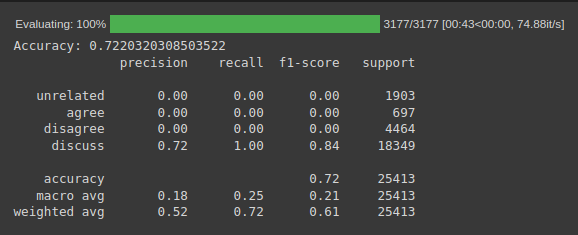